<a href="https://colab.research.google.com/github/nek07/inDrive_hackathon/blob/main/modeltraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Установка зависимостей


In [ ]:
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu121
!pip install ultralytics --upgrade
!pip install ultralytics==8.0.118 scikit-learn pillow tqdm opencv-python albumentations -q
import zipfile, os

import os
import shutil
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

2. Загрузка датасета


In [ ]:

import zipfile

zip_path = '/content/dad3.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")

# Проверим структуру
!tree dataset -L 2

/bin/bash: line 1: tree: command not found


3. Создание ямл файла на основе названий классов и фолдеров


In [ ]:
import os
from pathlib import Path

train_dir = Path("dataset/train")
val_dir = Path("dataset/valid")

classes = [d.name for d in train_dir.iterdir() if d.is_dir()]
classes.sort()
print("Классы:", classes)

yaml_content = f"""
names: {classes}
train: {str(train_dir)}
val: {str(val_dir)}
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)

print(open("data.yaml").read())

Классы: ['clean', 'dirty', 'slightly dirty', 'super clean', 'super dirty']

names: ['clean', 'dirty', 'slightly dirty', 'super clean', 'super dirty']
train: dataset/train
val: dataset/valid



4. Тренировка моделей

In [ ]:
import torch
from ultralytics import YOLO

# Регистрируем безопасный класс для загрузки
torch.serialization.add_safe_globals([YOLO])

# Загружаем предобученную модель классификации
# model = YOLO("yolov8n-cls.pt", task="classify")  # или yolov8s-cls.pt

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")  # лучше взять s или m, nano слишком маленькая для редких классов

# Параметры обучения
model.train(
    data="/content/data.yaml",  # путь к твоему yaml с датасетом
    epochs=10,                  # чуть больше эпох для мелких классов
    imgsz=640,
    batch=16,
    device=0,
)

In [ ]:
results = model.train(
    data="/content/dataset/",
    epochs=100,                     # больше эпох (мало данных → модель может учиться дольше)
    imgsz=224,                      # можно увеличить до 320 или 416
    batch=8,                        # уменьшим батч (так лучше при малом датасете)
    lr0=5e-4,                       # понижаем learning rate, чтобы не "перепрыгивал"
    patience=15,                    # дольше ждем перед ранней остановкой
    device=0 if torch.cuda.is_available() else "cpu",
    project="car_condition_project",
    name="exp_2class",               # новое имя эксперимента
    augment=True,                   # включаем аугментации (увеличиваем разнообразие данных)
    dropout=0.2                     # добавляем регуляризацию (если поддерживается)
)


Тест


YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs

0: 224x224 dirty 0.57, clean 0.43, 7.6ms
Speed: 3.7ms preprocess, 7.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
Предсказано: dirty (0.57)


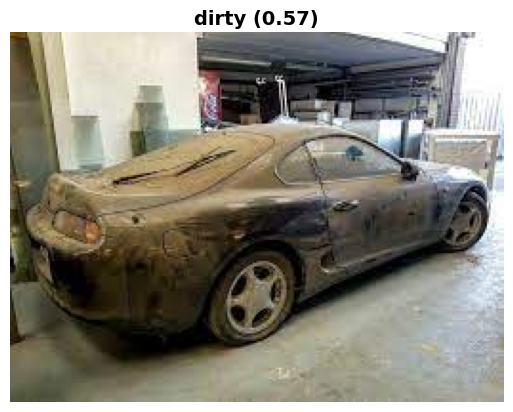

clean: 0.429
dirty: 0.571


In [ ]:
import torch
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

# 1. Загружаем обученную модель
model = YOLO("/content/car_condition_project/exp_2class/weights/best.pt")

# 2. Настройки (float32, GPU если есть)
model.fuse()
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.model.float()

# 3. Загружаем изображение
img_path = "/content/images (7).jpg"  # поменяй на свой путь
image = Image.open(img_path).convert("RGB")

# 4. Прогон через модель
results = model(image)
res = results[0]

# 5. Достаём предсказание
class_id = int(res.probs.top1)
class_name = res.names[class_id]
confidence = float(res.probs.top1conf)

print(f"Предсказано: {class_name} ({confidence:.2f})")

# 6. Визуализация фото + подпись
plt.imshow(image)
plt.axis("off")
plt.title(f"{class_name} ({confidence:.2f})", fontsize=14, weight="bold")
plt.show()

# 7. (опционально) выводим все вероятности
for i, prob in enumerate(res.probs.data.tolist()):
    print(f"{res.names[i]}: {prob:.3f}")



image 1/1 /content/dataset/test/images/Dent_Damage_7514_jpg.rf.505f38c6871462816a941723cc41d37d.jpg: 384x640 2 Damages, 11.5ms
Speed: 2.4ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict13


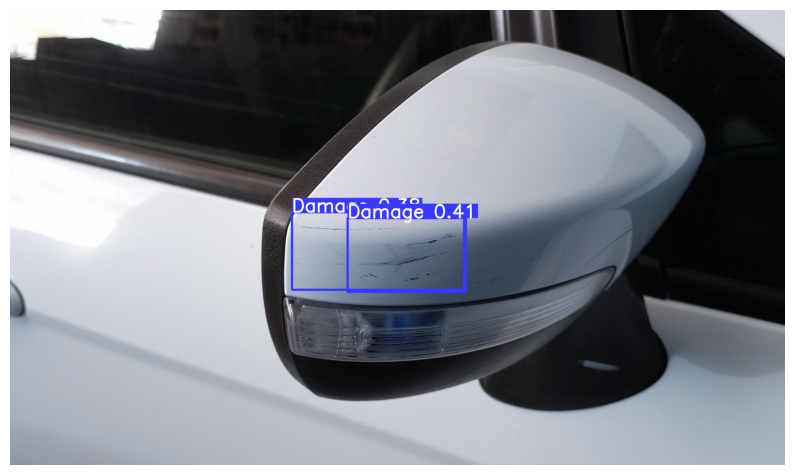

In [ ]:
import torch
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

# Загружаем обученную модель
model = YOLO("/content/runs/detect/train3/weights/best.pt")

# Путь к картинке для проверки
img_path = "/content/dataset/test/images/Dent_Damage_7514_jpg.rf.505f38c6871462816a941723cc41d37d.jpg"  # замени на свою картинку

# Делаем предсказание
results = model(img_path, save=True, imgsz=640, conf=0.3)

# save=True сохранит результат с боксами в runs/detect/predict/

# --- Визуализация прямо в ноутбуке ---
# Берем первую картинку с результатами
res_plotted = results[0].plot()

# Показываем через matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(res_plotted)
plt.axis("off")
plt.show()


In [ ]:
import os
import torch
from ultralytics import YOLO
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Загружаем модель ===
model = YOLO("/content/runs/detect/train5/weights/best.pt")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# === 2. Путь к тесту ===
test_dir = "/content/dataset/test/images"  # Roboflow обычно кладет сюда
labels_dir = "/content/dataset/test/labels"

# === 3. Собираем список файлов ===
img_files = [f for f in os.listdir(test_dir) if f.endswith(".jpg") or f.endswith(".png")]

y_true = []
y_pred = []

for img_name in img_files:
    # путь к картинке и лейблу
    img_path = os.path.join(test_dir, img_name)
    label_path = os.path.join(labels_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

    # читаем ground truth класс
    with open(label_path, "r") as f:
        gt_lines = f.readlines()
    # YOLO label: class x_center y_center w h
    gt_classes = [int(line.split()[0]) for line in gt_lines]

    # предсказание
    results = model(img_path, device=device, verbose=False)[0]
    pred_classes = results.boxes.cls.cpu().numpy().astype(int).tolist()

    # ⚠️ Простейшее сравнение: берем первый GT и первый предикт
    if len(gt_classes) > 0 and len(pred_classes) > 0:
        y_true.append(gt_classes[0])
        y_pred.append(pred_classes[0])

# === 4. Метрики ===
print("\n📊 Классификационный отчет:")
print(classification_report(y_true, y_pred))

acc = accuracy_score(y_true, y_pred)
print(f"✅ Финальная точность (Accuracy): {acc:.2f} ({acc*100:.1f}%)")

# === 5. Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Acc={acc*100:.1f}%)")
plt.show()
